# Zastosowanie algorytmu NSGA2 dla Problemu Plecakowego

**Dane**
1. Zbiór przedmiotów - każdy posiada wagę oraz wartość z przedziału \[0, 1).
2. Plecak posiadają znaną, skończoną pojemność k.
3. Wybierany jest podzbiór danego zbioru przedmiotów, mieszczący się w plecaku - suma wag mniejsza, bądź równa k.

**Cel**

Maksymalizacja sumarycznej wartości wybranych przedmiotów.

In [2]:
from random import random, randrange

**Algorytm NSGA2**

Dane: zbiór przedmiotów, ilość generacji, rozmiar populacji, k oraz prawdopodobieństwo mutacji.

1. Generowana jest populacja początkowa o danym rozmiarze (_Chromosome.random_) w postaci chromosomów reprezentowanych przez listy bitów, których długość jest równa ilości przedmiotów.
2. Dla każdej kolejnej generacji wykonywane są w pętli kolejne punkty.
3. Wykonywana jest operacja selekcji turniejowej - powstaje lista par rodziców.
4. Wykonywana jest operacja crossoveru - generowany jest zbiór dzieci.
5. Wykonywana jest operacja mutacji dzieci - z zadanym prawdopodobieństwem. Dzieci dodawane są do bieżącej populacji.
6. Wykonywany jest algorytm "Non-dominated sorting".
7. Wykonywany jest algorytm "Crowding distance sorting".
8. Usuwane są duplikaty z populacji (celem optymalizacji).

Otrzymany wynik to posortowana lista chromosomów, zatem pierwszy z nich jest "najlepszym" osobnikiem.

### Klasy modelowe

In [3]:
class Item:
    def __init__(self, weight, value):
        self.weight = weight
        self.value = value
    
    def __str__(self):
        return f"Weight: {self.weight} | Value: {self.value}"

In [4]:
class Chromosome:
    def __init__(self, size, selected=[]):
        self.size = size
        self.selected = selected

    @staticmethod
    def random(size):
        selected = []
        for i in range(size):
            selected.append(random() >= 0.5)
        return Chromosome(size, selected)

    def weightFitness(self, items):
        sum = 0
        for item in self.getSelectedItems(items):
            sum += item.weight
        return sum

    def valueFitness(self, items, maxWeight):
        sum = 0
        for item in self.getSelectedItems(items):
            sum += item.value
        return -1 if self.weightFitness(items) > maxWeight or self.weightFitness(items) == 0 else sum

    def getSelectedItems(self, items):
        selectedItems = []
        for el in zip(self.selected, items):
            if el[0]:
                selectedItems.append(el[1])
        return selectedItems

    def dominates(self, other, items, maxWeight):
        thisValue = self.valueFitness(items, maxWeight)
        thisWeight = self.weightFitness(items)
        otherValue = other.valueFitness(items, maxWeight)
        otherWeight = other.weightFitness(items)
        if (thisValue >= otherValue and thisWeight < otherWeight) or (thisValue > otherValue and thisWeight <= otherWeight):
            return 1
        elif (thisValue <= otherValue and thisWeight > otherWeight) or (thisValue < otherValue and thisWeight >= otherWeight):
            return -1
        else:
            return 0

    def clone(self):
        return Chromosome(self.size, self.selected.copy())

    def __str__(self):
        return f"{self.size} {self.selected}"

    def isEqual(self, obj):
        return self.size == obj.size and self.selected == obj.selected

    @staticmethod
    def removeDuplicated(chromosomes):
        newList = []

        def exists(x):
            for el in newList:
                if el.isEqual(x):
                    return True
            return False

        for c in chromosomes:
            if not exists(c):
                newList.append(c)
        return newList

In [5]:
class ChromosomeWrapper:
    def __init__(self, chromosome):
        self.chromosome = chromosome

    @staticmethod
    def fromChromosomes(chromosomes):
        pass

    @staticmethod
    def toChromosomes(wrapperList):
        chromosomes = []
        for wrapper in wrapperList:
            chromosomes.append(wrapper.chromosome)
        return chromosomes

### Operacje genetyczne

1. **Crossover** - wybierany jest punkt podziału, geny przed tym podziałem są dziedziczone po rodzicu 1, a za podziałem po rodzicu 2.
2. **Mutation** - z danym prawdopodobieństwem odwracane są poszczególne geny.
3. **TournamentSelection** - wybieramy dwa losowe chromosomy i wybieramy dominujący. Remis jest rozpatrywany jako rzut monetą.

In [6]:
class GeneticOperations:

    def __init__(self, mutationProbability, items):
        self.mutationProbability = mutationProbability
        self.items = items

    def crossover(self, parent1, parent2):
        selected = []
        sliceIndex = randrange(parent1.size)
        for i in range(sliceIndex):
            selected.append(parent1.selected[i])
        for i in range(sliceIndex, parent1.size):
            selected.append(parent1.selected[i])
        return Chromosome(parent1.size, selected)

    def mutation(self, chromosome):
        selected = []
        for i in range(chromosome.size):
            if random() >= self.mutationProbability:
                selected.append(not chromosome.selected[i])
            else:
                selected.append(chromosome.selected[i])
        return Chromosome(chromosome.size, selected)

    def tournamentSelection(self, chromosomes, maxWeight):
        idx1 = randrange(len(chromosomes))
        idx2 = randrange(len(chromosomes))
        dominate = chromosomes[idx1].dominates(chromosomes[idx2], self.items, maxWeight)
        if dominate == 1:
            return chromosomes[idx1]
        elif dominate == -1:
            return chromosomes[idx2]
        elif random() < 0.5:
            return chromosomes[idx1]
        else:
            return chromosomes[idx2]

    def selection(self, chromosomes, maxWeight):
        result = []
        for i in range(len(chromosomes)):
            result.append([self.tournamentSelection(chromosomes, maxWeight), self.tournamentSelection(chromosomes, maxWeight)])
        return result

### Crowding distance sorting

1. Wszystkie elementy są inicjalizowane z crowdingDistance = 0.
2. Elementy są sortowane po fitnessie. Następnie ustawiane jest dla max crowdingDistance = inf.
3. Elementy ze środka przedziału \[min, max\] mają ustawiane crowdingDistance zgodnie z metryką taksówkową względem wartości fitnessu sąsiadów.
4. Elementy są sortowane malejąco względem crowdingDistance - NSGA odrzuci pewną prawą część listy.

In [7]:
class CrowdingDistanceChromosomeWrapper(ChromosomeWrapper):
    def __init__(self, chromosome):
        super().__init__(chromosome)
        self.crowdingDistance = 0

    @staticmethod
    def fromChromosomes(chromosomes):
        cdList = []
        for c in chromosomes:
            cdList.append(CrowdingDistanceChromosomeWrapper(c))
        return cdList

In [8]:
class CrowdingDistanceSort:
    def __init__(self, items):
        self.items = items

    def sort(self, cdList, maxWeight):
        maxByValue = []
        minByWeight = []
        maxValue = 0
        minValue = float('inf')
        maxWeight = 0
        minWeight = float('inf')
        for cd in cdList:
            valueFitness = cd.chromosome.valueFitness(self.items, maxWeight)
            if valueFitness > maxValue:
                maxValue = valueFitness
                maxByValue = [cd]
            if valueFitness < minValue:
                minValue = valueFitness
            if valueFitness == maxValue:
                maxValue = valueFitness
                maxByValue.append(cd)
            weightFitness = cd.chromosome.weightFitness(self.items)
            if weightFitness > maxWeight:
                maxWeight = weightFitness
                maxByValue = [cd]
            if weightFitness < minWeight:
                minWeight = weightFitness
                minByWeight = [cd]
            if weightFitness == minWeight:
                minWeight = weightFitness
                minByWeight.append(cd)
                
        for m in maxByValue:
            m.crowdingDistance = float('inf')
        for m in minByWeight:
            m.crowdingDistance = float('inf')
        valueDiffrence = maxValue - minValue
        weightDiffrence = maxWeight - minWeight
        cdList.sort(key=lambda cd: cd.chromosome.valueFitness(self.items, maxWeight))
        for i in range(1, len(cdList) - 1):
            cdList[i].crowdingDistance = (cdList[i + 1].chromosome.valueFitness(self.items, maxWeight) - cdList[i - 1].chromosome.valueFitness(self.items, maxWeight))/valueDiffrence
            cdList[i].crowdingDistance += (cdList[i + 1].chromosome.weightFitness(self.items) - cdList[i - 1].chromosome.weightFitness(self.items))/weightDiffrence

        cdList.sort(reverse=True, key=lambda cd: cd.crowdingDistance)
        return cdList

### Non-dominatinated sorting

1. Rozpatrujemy dla każdej pary elementów z populacji, który chromosom nad którym dominuje (uaktualniamy listę chromosomów _dominatedBy_, przez które bieżący jest zdominowany oraz liczbę _dominationCount_ wskazującą nad iloma bieżący dominuje).
2. Wybieramy z populacji wszystkie niedominujące elementy. Odpowiednio zmniejszamy _dominationCount_ dla elementów, które nad nimi dominowały.
3. Do wynikowej listy dodajemy taki podzbiór populacji, a następnie powtarzamy kroki 2-3 do momentu, gdy w populacji nie będzie istniał żaden element niedominujący (_dominationCount=0_) lub wszystkie elementy populacji zostaną rozpatrzone.

In [9]:
class NonDominatedSortChromosomeWrapper(ChromosomeWrapper):
    def __init__(self, chromosome):
        super(NonDominatedSortChromosomeWrapper, self).__init__(chromosome)
        self.dominationCount = 0
        self.dominatedBy = []

    @staticmethod
    def fromChromosomes(chromosomes):
        ndsList = []
        for c in chromosomes:
            ndsList.append(NonDominatedSortChromosomeWrapper(c))
        return ndsList

In [10]:
class NonDominatedSort:
    def __init__(self, items):
        self.items = items

    def sort(self, ndsList, maxWeight):
        frontList = []
        for i in range(len(ndsList) - 1):
            for j in range(i + 1, len(ndsList)):
                dominateResult = ndsList[i].chromosome.dominates(ndsList[j].chromosome, self.items, maxWeight)
                if dominateResult == 1:
                    ndsList[j].dominationCount += 1
                    ndsList[i].dominatedBy.append(ndsList[j])
                elif dominateResult == -1:
                    ndsList[i].dominationCount += 1
                    ndsList[j].dominatedBy.append(ndsList[i])
        nonDominantExists = True
        while nonDominantExists:
            nonDominantExists = False
            currentFront = []           
            dominatedList = []
            for i in range(len(ndsList)):
                if ndsList[i].dominationCount == 0:
                    nonDominantExists = True
                    ndsList[i].dominationCount = -1
                    currentFront.append(ndsList[i])
                    for dominated in ndsList[i].dominatedBy:
                        dominatedList.append(dominated)
            for dominated in dominatedList:
                dominated.dominationCount -= 1
            if len(currentFront) > 0:
                frontList.append(currentFront)
        return frontList

### NSGA2

In [11]:
class Nsga:
    def __init__(self, mutationProbability, items):
        self.items = items
        self.geneticOperations = GeneticOperations(mutationProbability, items)
        self.CrowdingDistanceSort = CrowdingDistanceSort(items)
        self.nonDominatedSort = NonDominatedSort(items)

    def run(self, nrGeneration, populationSize, maxWeight):
        bestResults = []
        bestWeights = []
        chromosomes = []
        for i in range(populationSize):
            chromosomes.append(Chromosome.random(len(self.items)))
        for currentGeneration in range(nrGeneration):
            for i in range(len(chromosomes), populationSize):
                chromosomes.append(Chromosome.random(len(self.items)))
            selectedPairParents = self.geneticOperations.selection(chromosomes, maxWeight)
            children = []
            for selectedParents in selectedPairParents:
                children.append(self.geneticOperations.crossover(selectedParents[0], selectedParents[1]))

            mutated = list(map(lambda child: self.geneticOperations.mutation(child), children))
            children = Chromosome.removeDuplicated(mutated)

            chromosomes = [*chromosomes, *children]
            fronts = self.nonDominatedSort.sort(NonDominatedSortChromosomeWrapper.fromChromosomes(chromosomes), maxWeight)
            newPopulation = []
            currentFront = 0
            while currentFront < len(fronts) and len(newPopulation) + len(fronts[currentFront]) <= populationSize:
                newPopulation = [*newPopulation, *NonDominatedSortChromosomeWrapper.toChromosomes(fronts[currentFront])]
                currentFront += 1
            selected = self.CrowdingDistanceSort.sort(
                CrowdingDistanceChromosomeWrapper.fromChromosomes(NonDominatedSortChromosomeWrapper.toChromosomes(fronts[currentFront])), maxWeight)
            newPopulation = [*newPopulation, *CrowdingDistanceChromosomeWrapper.toChromosomes(
                selected[:(populationSize - len(newPopulation))])]
            chromosomes = Chromosome.removeDuplicated(newPopulation)[:min(populationSize, len(newPopulation))]
            bestResults.append(chromosomes[0].valueFitness(self.items, maxWeight))
            bestWeights.append(chromosomes[0].weightFitness(self.items))
        return [chromosomes, bestResults, bestWeights]

### Test

In [20]:
from KnackpackData import weights,values
import numpy as np

def naive(itemsNumber, w, v):
    solution = []
    sum = 0
    for i in range(itemsNumber):
        if w[i] < v[i]:
            solution.append(True)
            sum += w[i]
        else:
            solution.append(False)
    print(sum)        
    return solution        

def test(itemsNumber, mutationProbability, generationsNumber, populationSize, maxWeight):
    items = []
    for i in range(itemsNumber):
        item = Item(weights[i], values[i])
        items.append(item)
        print(f"{i+1}. {item}")

    nsga = Nsga(mutationProbability, items)
    bestChromosome = nsga.run(generationsNumber, populationSize, maxWeight)[0][0]
    result = nsga.run(generationsNumber, populationSize, maxWeight)
    print(f"Final weight: {bestChromosome.weightFitness(items)}")
    print(f"Final value: {bestChromosome.valueFitness(items, maxWeight)}")
    print(bestChromosome)
    n = naive(itemsNumber, weights, values)
    compare = []
    for i in range(itemsNumber):
        compare.append(bestChromosome.selected[i] == n[i])
    print(compare)    
    return result

In [ ]:
result = test(itemsNumber=16, mutationProbability=0.3, generationsNumber=5000, populationSize=100, maxWeight=3)
bestScores = result[1]
bestWeights = result[2]

1. Weight: 0.2620246750155817 | Value: 0.7941185757915866
2. Weight: 0.1586839721544656 | Value: 0.36126157241743073
3. Weight: 0.27812651949435974 | Value: 0.416103939570998
4. Weight: 0.45931688721456665 | Value: 0.5842581281103214
5. Weight: 0.32100054052016713 | Value: 0.7601717738058574
6. Weight: 0.5183928205975371 | Value: 0.18780840542641564
7. Weight: 0.26194292556514465 | Value: 0.2881671478120357
8. Weight: 0.9760852848774336 | Value: 0.6702188581602341
9. Weight: 0.7328145526904823 | Value: 0.49964826137201246
10. Weight: 0.11527422668314946 | Value: 0.1785686771635271
11. Weight: 0.38627506863435945 | Value: 0.4131413014246589
12. Weight: 0.6285011795397116 | Value: 0.1991952352050984
13. Weight: 0.12505792633559942 | Value: 0.5316994035870367
14. Weight: 0.9835486051436412 | Value: 0.8323707030679826
15. Weight: 0.4432248686451281 | Value: 0.18525094507204487
16. Weight: 0.7895583420239032 | Value: 0.9573592236712607


## Wizualizacje

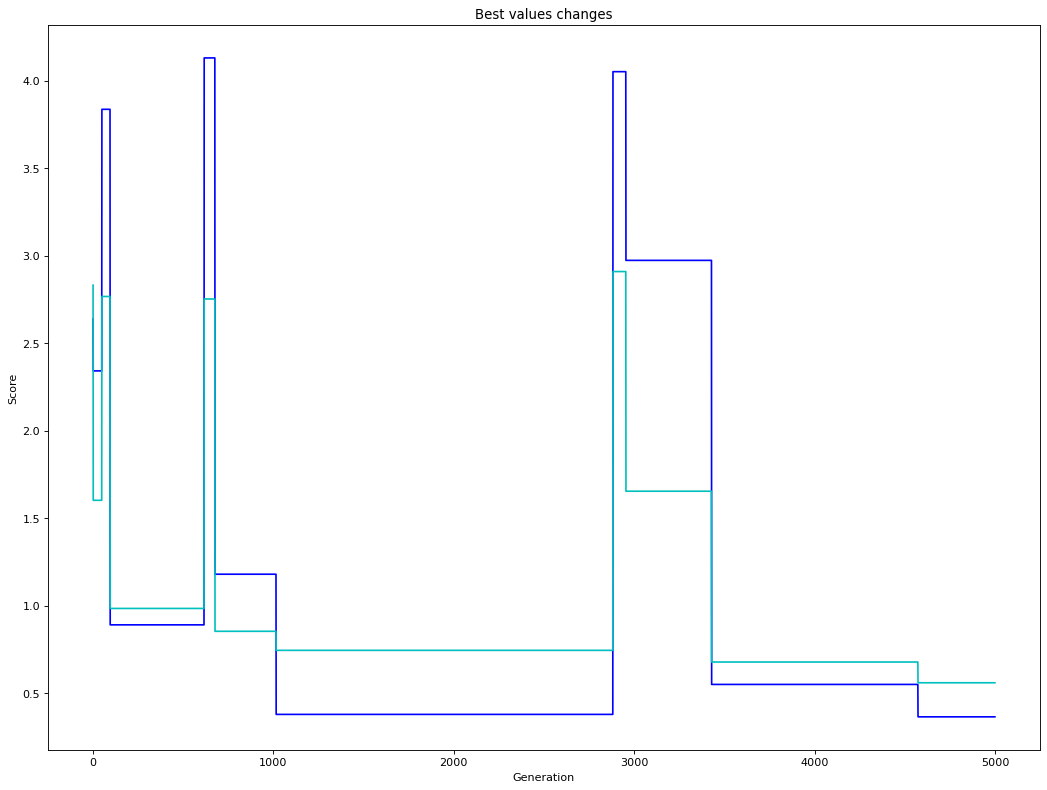

In [41]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(16, 12), dpi=80)
plt.plot(np.arange(np.array(bestScores).size), np.array(bestScores), color="b")
plt.plot(np.arange(np.array(bestWeights).size), np.array(bestWeights), color="c")
plt.ylabel('Score')
plt.xlabel('Generation')
plt.title('Best values changes')
plt.show()

In [2]:
def all_chromosomes(items_no):
    chromosome_lists = [[True], [False]]
    for i in range(items_no - 1):
        chros_len = len(chromosome_lists)
        for j in range(chros_len):
            ch = chromosome_lists.pop(0)
            ch2 = ch.copy()
            ch.append(True)
            ch2.append(False)
            chromosome_lists.append(ch)
            chromosome_lists.append(ch2)
    
    all_chros = []
    for i in range(len(chromosome_lists)):
        all_chros.append(Chromosome(items_no, selected=chromosome_lists[i]))
    return all_chros

In [3]:
def test_all(itemsNumber, maxWeight):
    items = []
    for i in range(itemsNumber):
        item = Item(weights[i], values[i])
        items.append(item)
        print(f"{i+1}. {item}")

    all_ch = all_chromosomes(16)
    nds = NonDominatedSort(items)
    fronts = nds.sort(NonDominatedSortChromosomeWrapper.fromChromosomes(all_ch), maxWeight)
    return fronts[0]

In [ ]:
test_all(16, 3)